Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [ ]:
#Linear & Ridge Regression example using sklearn

In [154]:
%%capture
import sys


# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'


In [248]:
import pandas as pd
import numpy as np
import sklearn as sk
import regex


def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, index_col='SALE DATE')
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df['BOROUGH'] = df['BOROUGH'].apply(str)
    df['SALE PRICE'] = df['SALE PRICE'].str.replace(r'\D+', '')
    df['SALE PRICE'] = df['SALE PRICE'].apply(float)
    df = df[df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS']
    df = df[df['SALE PRICE'] >= 100000] 
    df = df[df['SALE PRICE'] <= 200000]
    df
    
    
     
    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'


In [156]:
df = wrangle (filepath)


In [157]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,,
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000.0
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000.0
2019-01-03,4,FAR ROCKAWAY,01 ONE FAMILY DWELLINGS,2808.0,1920.0,200000.0
2019-01-07,2,WESTCHESTER,01 ONE FAMILY DWELLINGS,1400.0,1925.0,108000.0
2019-01-07,5,PORT IVORY,01 ONE FAMILY DWELLINGS,944.0,1910.0,125000.0


In [158]:
# Perform your exploratory data analysis here and
# modify the wrangle function above
df.head()
df.shape
df.columns


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE'],
      dtype='object')

In [232]:
#REMOVED NEIGHBORHOOD DUE TO SMALL SAMPLE SIZES 
X = df[['BOROUGH', 'GROSS SQUARE FEET', 'YEAR BUILT']]
Y = df['SALE PRICE']

In [233]:
cuttoff = pd.to_datetime('2019-04-01')
X_train, Y_train = X[X.index < cuttoff], Y[Y.index < cuttoff]
X_test, Y_test = X[X.index >= cuttoff], Y[Y.index >= cuttoff]

In [234]:
X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

((14, 3), (14,), (73, 3), (73,))

In [235]:
guess = Y_train.mean()
Y_pred = [guess] * len(Y_train)

from sklearn.metrics import mean_absolute_error
baseline_mae = mean_absolute_error(Y_train, Y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 28886.015387502346


In [236]:
import category_encoders as ce
ohe = ce.OneHotEncoder(use_cat_names = True)

XT_train = ohe.fit_transform(X_train)
XT_test = ohe.transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [174]:
XT_test.shape

(14, 48)

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [237]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

XT_train




,BOROUGH_4,BOROUGH_3,BOROUGH_2,BOROUGH_5,GROSS SQUARE FEET,YEAR BUILT
SALE DATE,,,,,,
2019-01-01,1,0,0,0,2001.0,1940.0
2019-01-02,0,1,0,0,2680.0,1899.0
2019-01-03,1,0,0,0,2808.0,1920.0
2019-01-07,0,0,1,0,1400.0,1925.0
2019-01-07,0,0,0,1,944.0,1910.0
...,...,...,...,...,...,...
2019-03-22,1,0,0,0,1200.0,1955.0
2019-03-25,0,1,0,0,1800.0,1933.0
2019-03-27,0,0,0,1,828.0,1925.0


In [243]:
selector = SelectKBest(score_func=f_regression, k = 6)
X_train_selected = selector.fit_transform(XT_train, Y_train)
X_test_selected = selector.transform(XT_test)
selected_mask = selector.get_support()
all_names = XT_train.columns
selected_names=all_names[selected_mask]
unselected_names=all_names[~selected_mask]

print('Feature Selected:')
for name in selected_names:
    print(name)

print('\n')


print('Feature Not Selected:')
for name in unselected_names:
    print(name)

print('\n')

Feature Selected:
BOROUGH_4
BOROUGH_3
BOROUGH_2
BOROUGH_5
GROSS SQUARE FEET
YEAR BUILT


Feature Not Selected:




In [249]:
#running for loop to see what number of features to use
for k in range(1, len(XT_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k = k)
  X_train_selected = selector.fit_transform(XT_train, Y_train)
  X_test_selected = selector.transform(XT_test)
 
  model = LinearRegression()
  model.fit(X_train_selected, Y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(Y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $35,612 

2 features
Test Mean Absolute Error: $36,267 

3 features
Test Mean Absolute Error: $35,455 

4 features
Test Mean Absolute Error: $35,407 

5 features
Test Mean Absolute Error: $35,380 

6 features
Test Mean Absolute Error: $35,380 



In [245]:
print(model.coef_[0])

875.5837612212393


**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [265]:
from sklearn.linear_model import Ridge

for k in range(1, len(XT_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k = k)
  X_train_selected = selector.fit_transform(XT_train, Y_train)
  X_test_selected = selector.transform(XT_test)
 
  model2 = Ridge(alpha = 1.1)
  model2.fit(X_train_selected, Y_train)
  y_pred = model2.predict(X_test_selected)
  mae = mean_absolute_error(Y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')




1 features
Test Mean Absolute Error: $35,612 

2 features
Test Mean Absolute Error: $36,186 

3 features
Test Mean Absolute Error: $35,488 

4 features
Test Mean Absolute Error: $35,437 

5 features
Test Mean Absolute Error: $35,419 

6 features
Test Mean Absolute Error: $35,395 



In [309]:
#using 6 coefficents for Ridge
from sklearn.linear_model import RidgeCV
selector = SelectKBest(score_func=f_regression, k = 6)
X_train_selected = selector.fit_transform(XT_train, Y_train)
X_test_selected = selector.transform(XT_test)
 
model2 = Ridge(alpha = .5)
model2.fit(X_train_selected, Y_train)
y_pred1 = model2.predict(X_train_selected)
y_pred2 = model2.predict(X_test_selected)
mae1 = mean_absolute_error(Y_train, y_pred1)
mae2 = mean_absolute_error(Y_test, y_pred2)
print(f'Test Mean Absolute Error: ${mae2:,.0f} \n', f'Training Mean Absolute Error: ${mae1:,.0f} \n')


Test Mean Absolute Error: $35,387 
 Training Mean Absolute Error: $28,476 



In [281]:
#using 6 coefficients for Linear

selector = SelectKBest(score_func=f_regression, k = 6)
X_train_selected = selector.fit_transform(XT_train, Y_train)
X_test_selected = selector.transform(XT_test)
 
model1 = LinearRegression()
model1.fit(X_train_selected, Y_train)
y1_pred1 = model1.predict(X_train_selected)
y1_pred2 = model1.predict(X_test_selected)
mae1x = mean_absolute_error(Y_train, y1_pred1)
mae2x = mean_absolute_error(Y_test, y1_pred2)
print(f'Test Mean Absolute Error: ${mae2x:,.0f} \n', f'Training Mean Absolute Error: ${mae1x:,.0f} \n')

Test Mean Absolute Error: $35,380 
 Training Mean Absolute Error: $28,460 



In [282]:
training_mae_lr = mae1x
test_mae_lr = mae2x

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 28459.765415939823
Linear Test MAE: 35379.92635571419


In [283]:
training_mae_r = mae1
test_mae_r = mae2

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 28475.577062801174
Ridge Test MAE: 35387.436835021734


In [288]:
# Caculate R^2 score.
from sklearn.metrics import r2_score
R2Training = r2_score(Y_train, y_pred1)
R2Testing = r2_score(Y_test, y_pred2)
print(R2Testing, R2Training)

0.008871278257168713 0.0319585928549837


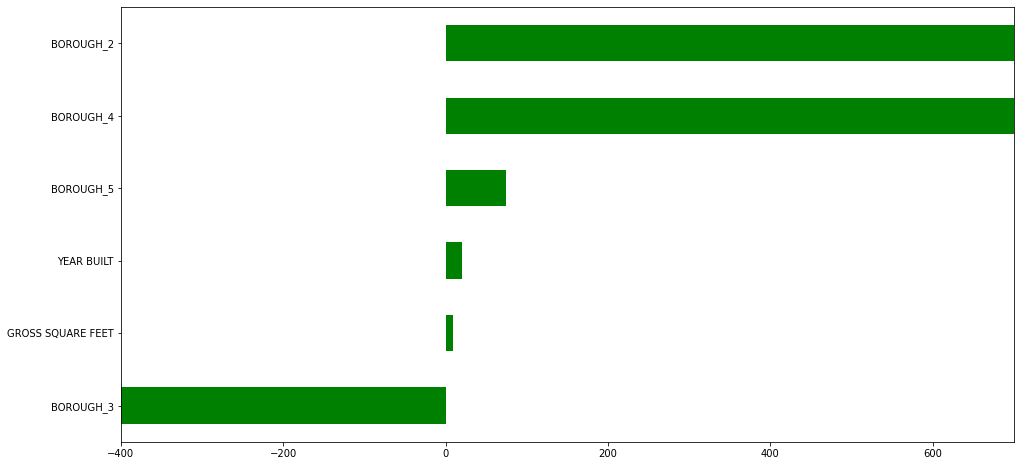

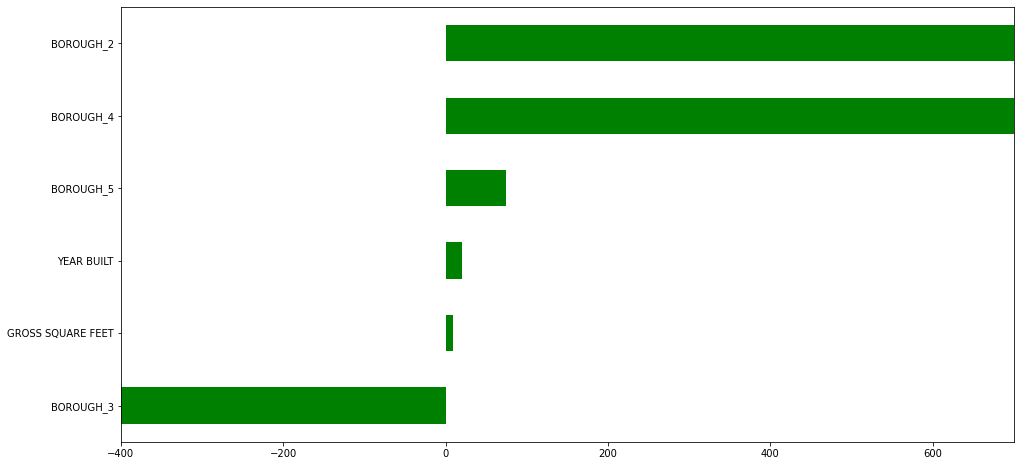

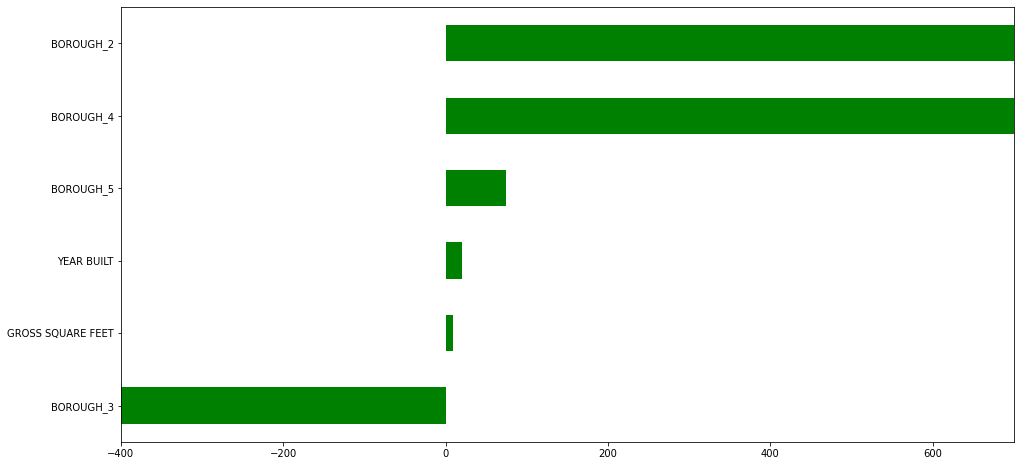

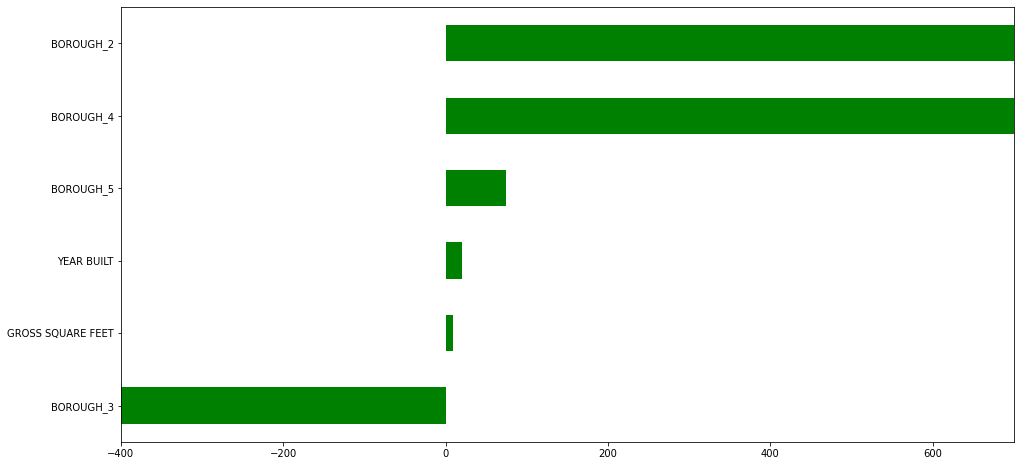

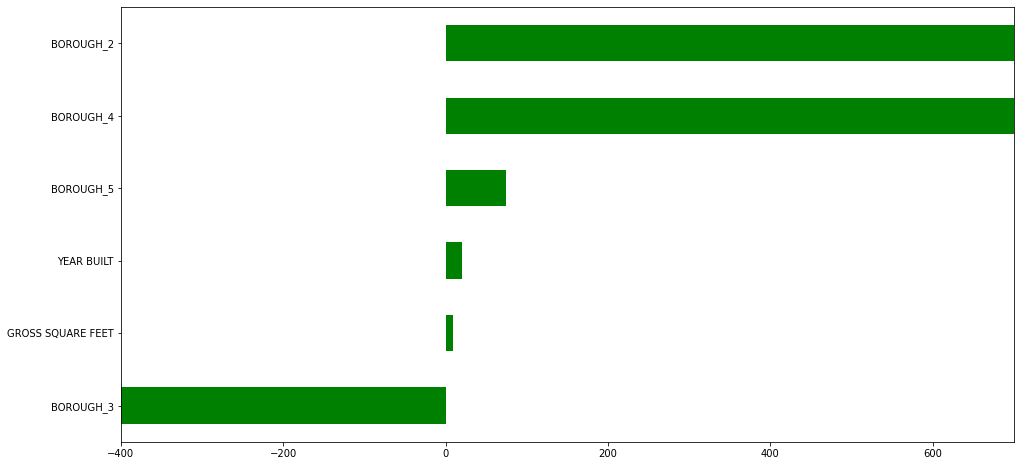

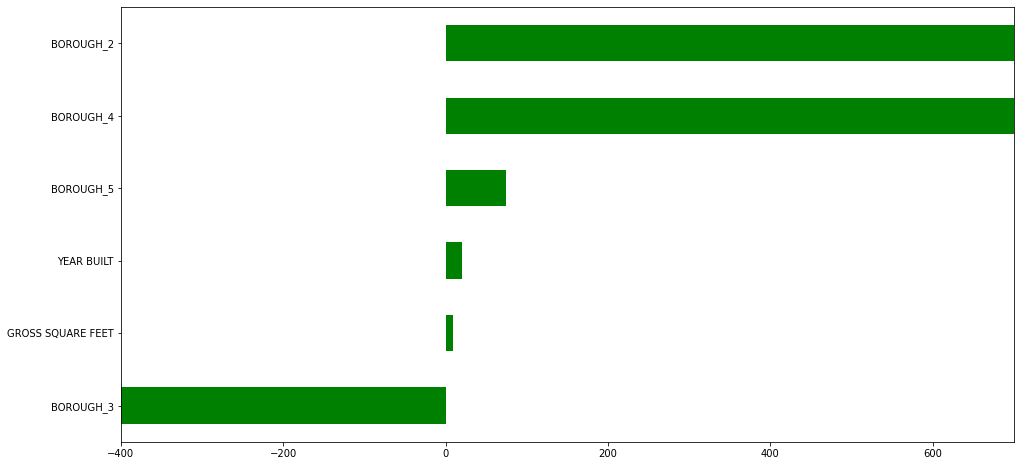

In [303]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model2 = Ridge(alpha=alpha, normalize=True)
  model2.fit(X_train_selected, Y_train)
  y_pred = model.predict(X_test_selected)

  coefficients = pd.Series(model.coef_, XT_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='green')
  plt.xlim(-400,700)
  plt.show()

#I removed the nighboorhood column so I only have 6 coefficients.  What I conclude from the r^2 scores is that this model still is overfit.  More data is required before borough should is used.  The number one  train.plot.scatter(feature, target, alpha=0.05)plt.plot(X_test[feature], y_pred)
